<a href="https://colab.research.google.com/github/sifulsidd/pytorch/blob/master/02_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the option)

## 1. Make classification data and get it ready

In [89]:
import sklearn

In [90]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [91]:
len(X), len(y)

(1000, 1000)

In [92]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [93]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [94]:
circles.label.value_counts()

,count
label,
1,500
0,500


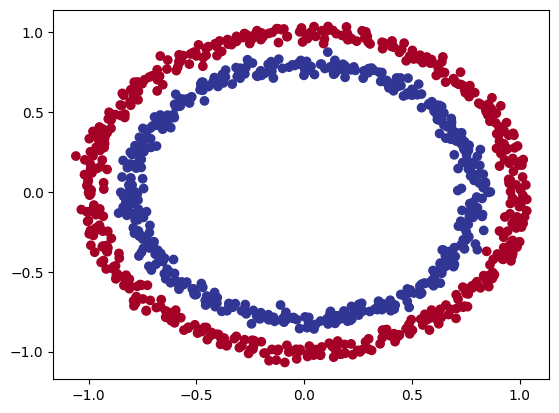

In [95]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu)

**Note**: The data we are working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [96]:
X.shape, y.shape

((1000, 2), (1000,))

In [97]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [98]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [99]:
import torch
torch.__version__

'2.6.0+cu124'

In [100]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [101]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [102]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [103]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [104]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # 0.2 = 20% of data will be test, 80% will be train
                                                    random_state=42) # same as torch.manual_seed but in scikit learn

In [105]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [106]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code, so our code will run on an accelerator (GPU) if there is one
2. Construct a model (subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [107]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [108]:
X_train, X_train.shape

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         ...,
         [ 0.0157, -1.0300],
         [ 1.0110,  0.1680],
         [ 0.5578, -0.5709]]),
 torch.Size([800, 2]))

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handing the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [109]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [110]:
# 1. Contrust a model that subclasses nn.Module
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    #  2. Create 2 nn.Linear() layers capable of handling shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features, more hidden features (out_features) to learn patterns on
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # in_features of next layer has to be equivalent to out_feature of previous layer, outputs a single feature(same shape as y)

    # self.two_linear_layers = nn.Sequential(
    #   nn.Linear(in_features=2, out_features=5),
    #   nn.Linear(in_features=5, out_features=1)
    # )

  # 3. Define forward() method that outlines forward pass, return a tensor
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2
    # return self.two_linear_layers(x)

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [111]:
next(model_0.parameters()).device

device(type='cpu')

In [112]:
# Let's replicate model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [113]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [114]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3948, -0.1807],
                      [-0.4035, -0.2421],
                      [-0.5283,  0.2522],
                      [ 0.5473, -0.6657],
                      [ 0.1642,  0.3653]])),
             ('0.bias', tensor([ 0.1282, -0.2518,  0.3691,  0.3716,  0.2644])),
             ('1.weight',
              tensor([[-0.0786, -0.1184,  0.0478, -0.0790, -0.1333]])),
             ('1.bias', tensor([0.2859]))])

In [115]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.3265],
        [0.3140],
        [0.2919],
        [0.3365],
        [0.1853],
        [0.1785],
        [0.2280],
        [0.1960],
        [0.2965],
        [0.3120]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [116]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built in options.

For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy (BCE) is

In [117]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to BCELoss
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss
# ) => same as BCEWithLogitsLoss()
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [118]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()

  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Train model

To train our model, we're going to need to build a training loop with the following steps

1. Forward pass
2. Calculate the loss
3. Optimize zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary crossentropy and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [119]:
# View the first 5 outputs of forward pass on test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5] # logits are like outputs of our model
y_logits

tensor([[0.3265],
        [0.3140],
        [0.2919],
        [0.3365],
        [0.1853]])

In [120]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [121]:
# Use the sigmoid activation function on model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs # value between 0 and 1 for how likely our model thinks it is a certain class

tensor([[0.5809],
        [0.5779],
        [0.5725],
        [0.5834],
        [0.5462]])

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y = 1` (class 1)
* `y_pred_probs` < 0.5, `y = 0` (class 0)

In [122]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [123]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [124]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as inputs
  loss = loss_fn(y_logits,
                 y_train) # The loss function is BCEWithLogitsLoss, so we pass in the logits
  # accuracy takes the y_pred and true value is the train functions
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()


  ### TESTING
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_accuracy = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

  # Print out what's happening
  if epoch % 50 == 0:
    print(f"Epochs: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_accuracy:2f}%")



Epochs: 0 | Loss: 0.70175, Acc: 50.00% | Test Loss: 0.70198, Test acc: 50.000000%
Epochs: 50 | Loss: 0.69357, Acc: 53.00% | Test Loss: 0.69397, Test acc: 53.000000%
Epochs: 100 | Loss: 0.69317, Acc: 50.88% | Test Loss: 0.69369, Test acc: 50.500000%
Epochs: 150 | Loss: 0.69307, Acc: 50.88% | Test Loss: 0.69377, Test acc: 50.000000%
Epochs: 200 | Loss: 0.69303, Acc: 51.12% | Test Loss: 0.69390, Test acc: 47.500000%
Epochs: 250 | Loss: 0.69301, Acc: 50.75% | Test Loss: 0.69403, Test acc: 47.500000%
Epochs: 300 | Loss: 0.69300, Acc: 51.12% | Test Loss: 0.69415, Test acc: 47.500000%
Epochs: 350 | Loss: 0.69299, Acc: 51.00% | Test Loss: 0.69426, Test acc: 47.000000%
Epochs: 400 | Loss: 0.69299, Acc: 50.88% | Test Loss: 0.69434, Test acc: 46.500000%
Epochs: 450 | Loss: 0.69298, Acc: 51.25% | Test Loss: 0.69441, Test acc: 46.000000%
Epochs: 500 | Loss: 0.69298, Acc: 51.25% | Test Loss: 0.69446, Test acc: 46.000000%
Epochs: 550 | Loss: 0.69298, Acc: 51.38% | Test Loss: 0.69451, Test acc: 46.000

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!"

To do so, we're going to import a function called `plot_decision_boundary()`

In [125]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
# if it doesn't exist, we get the contents of the url, then write contents of the request
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


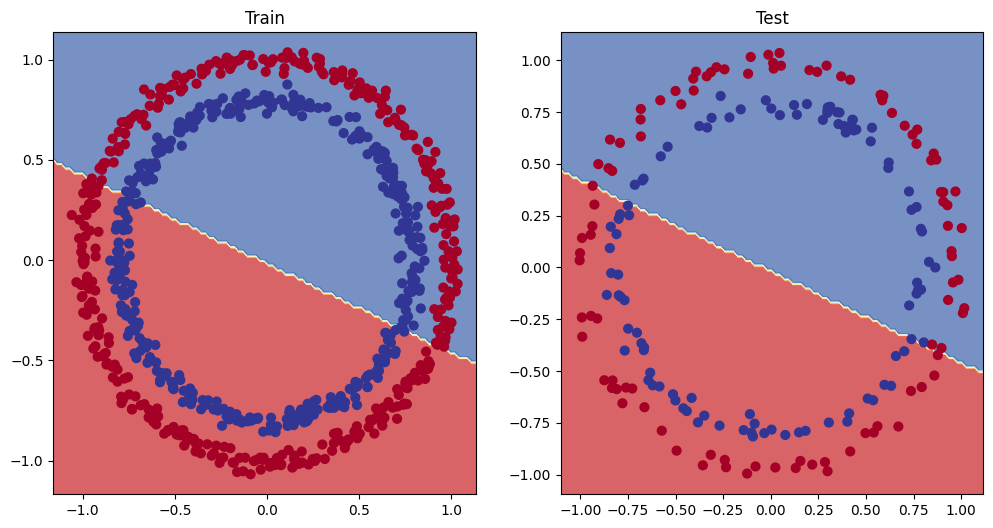

In [126]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer (more epochs)
* Changing the activation functions
* Change the learning rate   
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred to as **hyperparamaters**

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000


In [127]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [128]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # same as above
    return self.layer_3(self.layer_2(self.layer_1(x))) # This way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV2().to(device)
model_1, model_1.state_dict()

(CircleModelV2(
   (layer_1): Linear(in_features=2, out_features=10, bias=True)
   (layer_2): Linear(in_features=10, out_features=10, bias=True)
   (layer_3): Linear(in_features=10, out_features=1, bias=True)
 ),
 OrderedDict([('layer_1.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802]])),
              ('layer_1.bias',
               tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                        0.0667, -0.6984])),
              ('layer_2.weight',
               tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                      

In [129]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr= 0.1)

In [130]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):
  model_1.train()

  new_y_logits = model_1(X_train).squeeze()
  new_y_preds = torch.round(torch.sigmoid(new_y_logits))

  loss = loss_fn(new_y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=new_y_preds)

  optimizer.zero_grad()
  loss.backward() # backpropagation
  optimizer.step() # gradient descent

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_new_logits = model_1(X_test).squeeze()
    test_y_preds = torch.round(torch.sigmoid(test_new_logits))
    test_loss = loss_fn(test_new_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred = test_y_preds)

  if epoch % 50 == 0:
    print(f"Epochs: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epochs: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test acc: 51.00%
Epochs: 50 | Loss: 0.69322, Acc: 49.88% | Test Loss: 0.69324, Test acc: 50.00%
Epochs: 100 | Loss: 0.69305, Acc: 50.38% | Test Loss: 0.69379, Test acc: 48.00%
Epochs: 150 | Loss: 0.69300, Acc: 51.00% | Test Loss: 0.69415, Test acc: 47.00%
Epochs: 200 | Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69437, Test acc: 46.00%
Epochs: 250 | Loss: 0.69298, Acc: 51.62% | Test Loss: 0.69450, Test acc: 46.00%
Epochs: 300 | Loss: 0.69298, Acc: 51.62% | Test Loss: 0.69458, Test acc: 45.00%
Epochs: 350 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69462, Test acc: 45.50%
Epochs: 400 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69465, Test acc: 46.00%
Epochs: 450 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69466, Test acc: 46.00%
Epochs: 500 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69467, Test acc: 46.00%
Epochs: 550 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69467, Test acc: 46.00%
Epochs: 600 | Loss: 0.69298, Acc: 51.00% | 

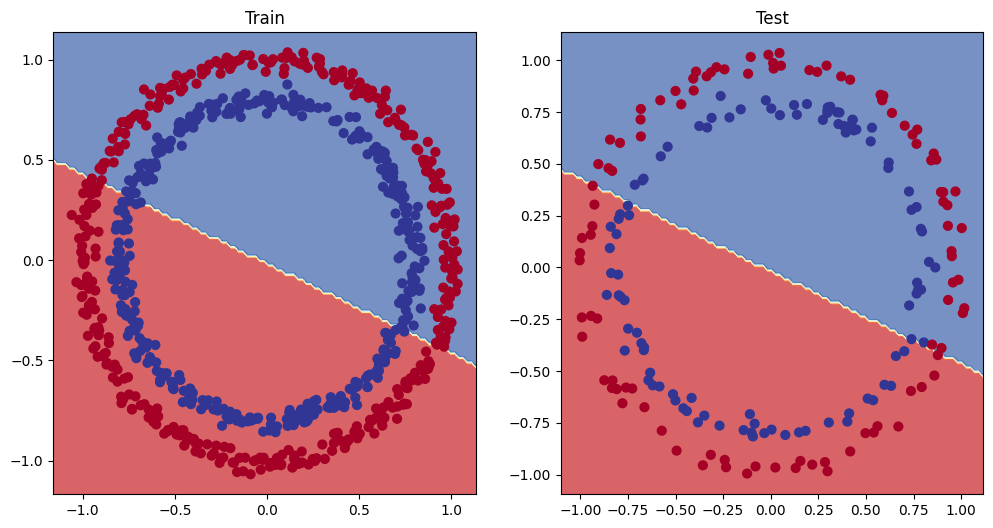

In [131]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem.

In [132]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [133]:
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set, 20% for testing
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

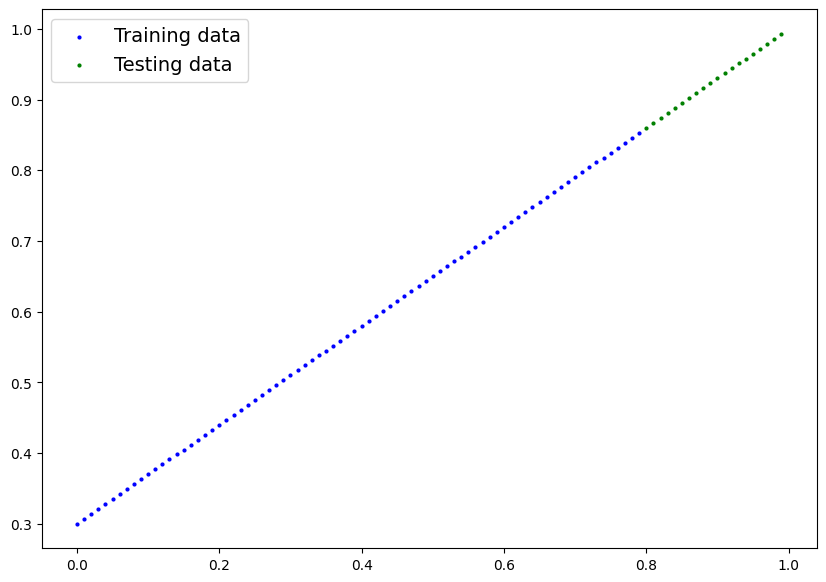

In [134]:
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)

In [135]:
X_train_regression[:10], y_train_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

In [136]:
model_1

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting `model_1` to fit a straight line

In [137]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [138]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [139]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

epochs = 1000
for epoch in range(epochs):
  model_2.train()
  y_preds_regression = model_2(X_train_regression)

  loss = loss_fn(y_preds_regression, y_train_regression)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    y_test_preds_regression = model_2(X_test_regression)
    test_loss = loss_fn(y_test_preds_regression, y_test_regression)

  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.7598584890365601 | Test Loss: 0.9110288619995117
Epoch: 50 | Loss: 0.03196067735552788 | Test Loss: 0.0010761826997622848
Epoch: 100 | Loss: 0.02857953868806362 | Test Loss: 0.0008127152686938643
Epoch: 150 | Loss: 0.027435224503278732 | Test Loss: 0.0016933738952502608
Epoch: 200 | Loss: 0.025325417518615723 | Test Loss: 0.002092066453769803
Epoch: 250 | Loss: 0.023305529728531837 | Test Loss: 0.002540290355682373
Epoch: 300 | Loss: 0.021374788135290146 | Test Loss: 0.0030509470961987972
Epoch: 350 | Loss: 0.019256386905908585 | Test Loss: 0.0035945475101470947
Epoch: 400 | Loss: 0.019644945859909058 | Test Loss: 0.003407782409340143
Epoch: 450 | Loss: 0.019365768879652023 | Test Loss: 0.0032683848403394222
Epoch: 500 | Loss: 0.019402235746383667 | Test Loss: 0.0038725673221051693
Epoch: 550 | Loss: 0.019193794578313828 | Test Loss: 0.00379655952565372
Epoch: 600 | Loss: 0.019032442942261696 | Test Loss: 0.003789058420807123
Epoch: 650 | Loss: 0.018889281898736954 |

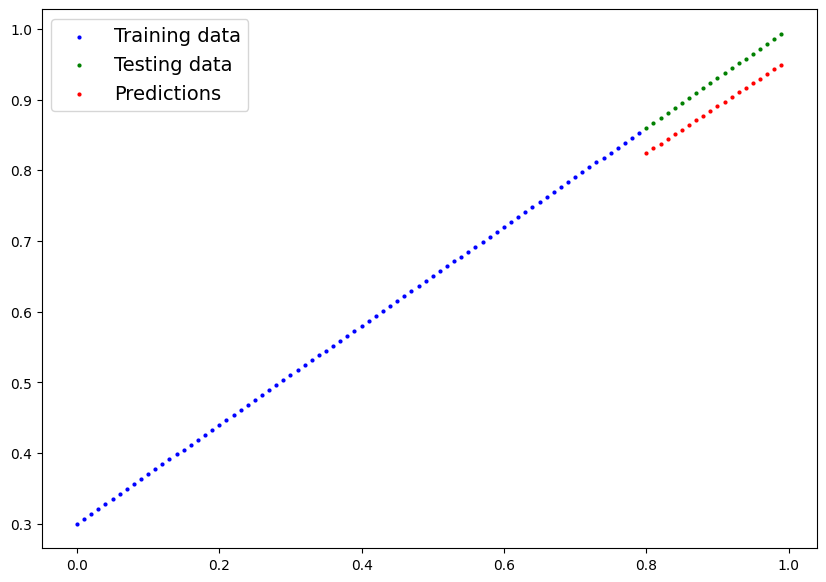

In [140]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight or non-straight lines?"

Or in machine learning terms, an infinite (but really is finite) amount of linear and non-linear functions

### 6.1 Recreating non-linear data (red and blue circles)

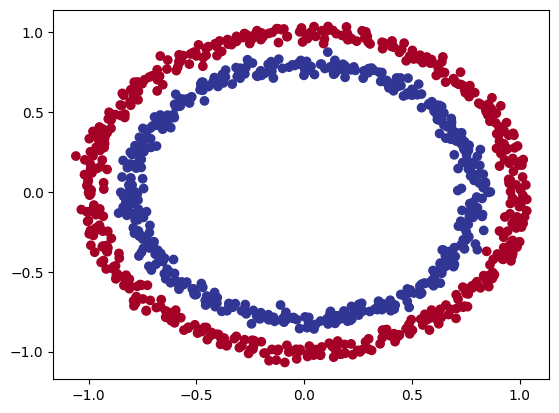

In [141]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [142]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-linear functions which are potentially able to find patterns in data.

In [143]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is nonlinear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions? Put in between each layer
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [144]:
# Loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity

In [147]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze() # Make sure to squeeze or we get torch.Size error
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze() # squeeze again
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69289 | Accuracy: 50.00% | Test Loss: 0.69312 | Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69114 | Accuracy: 52.88% | Test Loss: 0.69101 | Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68976 | Accuracy: 53.25% | Test Loss: 0.68938 | Test Accuracy: 55.50%
Epoch: 300 | Loss: 0.68793 | Accuracy: 53.00% | Test Loss: 0.68721 | Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68513 | Accuracy: 52.75% | Test Loss: 0.68408 | Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68097 | Accuracy: 52.75% | Test Loss: 0.67936 | Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67508 | Accuracy: 54.50% | Test Loss: 0.67277 | Test Accuracy: 56.50%
Epoch: 700 | Loss: 0.66648 | Accuracy: 58.38% | Test Loss: 0.66310 | Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65140 | Accuracy: 64.00% | Test Loss: 0.64738 | Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62324 | Accuracy: 74.00% | Test Loss: 0.62111 | Test Accuracy: 79.00%
